# NGC 4278

In this notebook I will do the continuum calibration of NGC 4278. This includes cross-calibration and self-calibration. 

In [1]:
# Header Cell. You should NOT rerun this block if you have not restarted the kernel.
from apercal import lib
lib.setup_logger('info', logfile='/home/frank/ngc4278-tutorial.log')
import pylab as pl
%matplotlib inline
import os
from apercal import calibrate
ccal = calibrate.crosscal()
scal = calibrate.wselfcal()

root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/frank/ngc4278-tutorial.log


Setup logger with lib.setup_logger()


In [2]:
cal1 = calibrate.source()
path = '/home/frank/tutorials/tutorial-ngc4278'
cal1.path = path
cal1.ms = '10400803_S0_T0.MS'
cal1.vis = 'cal1.uv'
cal1.update()
print cal1.vis

cal2 = calibrate.source()
cal2.path = path
cal2.ms = '10400805_S0_T0.MS'
cal2.vis = 'cal2.uv'
cal2.update()

src1 = calibrate.source()
src1.path = path
src1.ms = '10400804_S0_T0.MS'
src1.vis = 'src1.uv'
src1.update()

src2 = calibrate.source()
src2.path = path
src2.ms = '10400804_S0_T1.MS'
src2.vis = 'src2.uv'
src2.update()

src3 = calibrate.source()
src3.path = path
src3.ms = '10400804_S0_T2.MS'
src3.vis = 'src3.uv'
src3.update()

src = calibrate.source()
src.path = path
src.vis = 'src.uv'
src.update()

s0 = calibrate.source()
s0.path = path
s0.vis = 'src.uv_chan0'
s0.update()


cal1.uv


## Importing the Measurement Sets

The import data sets are in MS format. We use the ``ms2uvfits`` function to import that data. 

We will also import all the data sets in a single cell. 

In the previous cell we defined the source objects that we were going to use for the calibration. In the next cell we define a list with all the source files, and loop over this list to import the measurement sets. 

In [3]:
# First, define the source that you want to import
sources = [cal1, src1, src2, src3]

# Send this to the crosscal object. 
for source in sources:
    ccal.source = source
    ccal.setup()
    ccal.ms2uvfits()


crosscal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ngc4278
crosscal - WARNING : All outputs will be relative to this path.
ms2uvfits - INFO : ms2uvfits: Converting MS to UVFITS Format
ms2uvfits - INFO : MS: 10400803_S0_T0.MS
ms2uvfits - INFO : UVFITS: 10400803_S0_T0.UVF
ms2uvfits - INFO : Directory: 
masher - INFO : ms2uvfits multisource=T writesyscal=T fitsfile=10400803_S0_T0.UVF ms=10400803_S0_T0.MS combinespw=T 
basher - ERROR : 2015-10-09 14:16:38	INFO	MSFitsOutputAstron::writeFitsFile	Converting MeasurementSet /home/frank/tutorials/tutorial-ngc4278/10400803_S0_T0.MS to FITS file '10400803_S0_T0.UVF'
2015-10-09 14:16:38	INFO	MSFitsOutputAstron::writeMain	Writing DATA column
2015-10-09 14:16:39	INFO	MSFitsOutputAstron::writeFitsFile	Writing AIPS FQ table
2015-10-09 14:16:39	INFO	MSFitsOutputAstron::writeFQ	Found 1 spectral windows 
2015-10-09 14:16:39	INFO	MSFitsOutputAstron::writeFitsFile	Writing AIPS AN table
2015-10-09 14:16:39	SEVERE	MeasTable::dUTC(Doub

Just as we did above, we will loop over the source list to import the UVFITS files, converting them to **``MIRIAD``** UV format, doing the $T_{sys}$ calibration and some standard flagging.

In [4]:
# First, define the source that you want to import

for source in sources:
    # Send this to the crosscal object. 
    ccal.source = source

    ccal.setup()

    # Setup the WSRTFITS parameters. The inp() method simply shows you the variables that have already been set. 
    ccal.wsrtfits.inp()
    ccal.wsrtfits.in_ = source.uvf
    ccal.wsrtfits.out = source.vis+'.temp'
    # The go() method always returns the task output as a list of text.
    output = ccal.wsrtfits.go(rmfiles=True)

    # Do
    ccal.attsys.vis = source.vis+'.temp'
    ccal.attsys.out = source.vis
    ccal.attsys.go(rmfiles=True)

    # Replace the old vis with this new file
    #lib.basher('mv '+source.vis+'.temp '+source.vis)
    lib.basher('rm -r '+source.vis+'.temp')

    # Flag antenna 6, autocorrelations and for shadowing
    select = ['auto', 'shadow(25)']
    ccal.uvflag.vis = source.vis
    ccal.uvflag.flagval = 'flag'
    for s in select:
        ccal.uvflag.select = s
        ccal.uvflag.go()


crosscal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ngc4278
crosscal - WARNING : All outputs will be relative to this path.
miriad wsrtfits - INFO : velocity=optbary, task=wsrtfits, out=somefile.uv, in_=somefile.UVF, op=uvin
masher - INFO : wsrtfits velocity=optbary in_=10400803_S0_T0.UVF op=uvin out=cal1.uv.temp 
basher - ERROR : ### Warning [wsrtfits]:  Some unrecognised cards were written to the history file
### Warning [wsrtfits]:  Ignored random parameter INTTIM

miriad wsrtfits - INFO : Completed.
masher - INFO : attsys vis=cal1.uv.temp out=cal1.uv 
miriad attsys - INFO : Completed.
masher - INFO : uvflag vis=cal1.uv flagval=flag select=auto 
miriad uvflag - INFO : Completed.
masher - INFO : uvflag vis=cal1.uv flagval=flag select=shadow(25) 
miriad uvflag - INFO : Completed.
crosscal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ngc4278
crosscal - WARNING : All outputs will be relative to this path.
miriad wsrtfits - INFO : velocity=op

In [5]:
# MFCAL
ccal.mfcal.vis = cal1.vis
ccal.mfcal.interval = 10000
ccal.mfcal.edge = '10,50'
ccal.mfcal.refant = 2
output = ccal.mfcal.go()

masher - INFO : mfcal vis=cal1.uv edge=10,50 refant=2 interval=10000 
basher - ERROR : ### Warning [mfcal]:  Correlations flagged or edge-rejected: 327600

miriad mfcal - INFO : Completed.


Now I will concatenate source files and fix the header so that I can transfer the gains properly.

In [6]:
# UVCAT / UVCAL

ccal.source = src
ccal.setup()

ccal.uvcat.vis = src1.vis+','+src2.vis+','+src3.vis
ccal.uvcat.out = src.vis
output = ccal.uvcat.go()

ccal.puthd.in_ = src.vis+'/restfreq'
ccal.puthd.value ='1.420405752'
ccal.puthd.go()

ccal.puthd.in_ = src.vis+'/interval'
ccal.puthd.type = 'double'
ccal.puthd.value= '2.0'
ccal.puthd.go()

crosscal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ngc4278
crosscal - WARNING : All outputs will be relative to this path.
masher - INFO : uvcat vis=src1.uv,src2.uv,src3.uv out=src.uv 
miriad uvcat - INFO : Completed.
masher - INFO : puthd in_=src.uv/restfreq value=1.420405752 
miriad puthd - INFO : Completed.
masher - INFO : puthd in_=src.uv/interval type=double value=2.0 
miriad puthd - INFO : Completed.


['PUTHD: Version 1.0 13-dec-96',
 'New item interval created with datatype double']

In [7]:
# GPCOPY
ccal.gpcopy.vis = cal1.vis
ccal.gpcopy.out = src.vis
output = ccal.gpcopy.go()

masher - INFO : gpcopy vis=cal1.uv out=src.uv 
miriad gpcopy - INFO : Completed.


In [8]:
# UVLIN
ccal.uvlin.vis = src.vis
ccal.uvlin.chans = '50,300,400,600,601,800'
ccal.uvlin.order = 2
ccal.uvlin.mode = 'chan0'
ccal.uvlin.out = s0.vis
output = ccal.uvlin.go()

masher - INFO : uvlin vis=src.uv out=src.uv_chan0 mode=chan0 chans=50,300,400,600,601,800 order=2 
miriad uvlin - INFO : Completed.


## Deep Image

In [11]:
# scal.invert is attached to the invert task.
# Defaults for the map and beam parameters are set in the next block
# Change parameters as follows:

scal.source = s0
scal.output = 'output'

scal.invert.robust = -2.0
scal.invert.slop = '0.5'
scal.invert.imsize ='1500'
scal.invert.cell = 4
scal.invert.options='mfs,double'
scal.invert.select = '-uvrange(0,0.5)'

# scal.clean is attached to the clean task 
# Defaults for the map, beam and model fields are set in the next block
# Change parameters as follows:
scal.clean.cutoff = 5e-4
scal.clean.niters=100000

# scal.maths is attached to the MATHS task
# Parameters are shown here for illustration. 
# Change parameters as follows:
scal.maths = lib.miriad('maths')
scal.maths.exp = 'map'
scal.maths.mask = 'map.gt.1e-3'
scal.maths.out = 'mask'

# scal.restor is attached to the restor task
# Change parameters as follows:
scal.restor.mode = 'clean'

# scal.imstat is attached to the imstat task

# SelfCal and Image Cycle Settings
# Number of Major Cycles
scal.num_selfcal = 3
# Number of minor cycles - The number of image cycles
scal.num_clean = 3

# The mask cutoffs will go from immax/cmin...
scal.cmin = 5
# to a minimum of imax/cmax
scal.cmax = 20
# If linear is True, then the mask cutoffs will decrease linearly.
# If linear is False, then the mask cutoffs will be decrease logarithmically, 
# with log10(cmin) and log10(cmax) as the minimum and maximum denominators respectively.
scal.linear = True 
# This is how much deeper than the mask cutoff that we will clean to.
scal.d = 10.
# Cleaning and masking will stop at 7*theoretical rms 
scal.nsigma = 7 
# dummy value for the image maximum
scal.immax = 0.0
scal.rmgains = False # Remove gains from vis file.

scal.setup()

scal.deep_image()

selfcal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ngc4278/output
selfcal - WARNING : All outputs will be relative to this path.
selfcal - INFO : Making symbolic/soft link to your visibility file
basher - ERROR : ln: failed to create symbolic link `./src.uv_chan0': File exists

masher - INFO : obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - ERROR : ### Informational [obsrms]:  inttime in minutes

miriad obsrms - INFO : Completed.
deep_image - INFO : Mask threshold: IMAX/5.0
masher - INFO : invert map=map slop=0.5 beam=beam cell=4 vis=src.uv_chan0 robust=-2.0 options=mfs,double select=-uvrange(0,0.5) imsize=1500 
basher - ERROR : ### Warning [invert]:  Visibilities rejected: 8682

miriad invert - INFO : Completed.
masher - INFO : imstat in_=map options=nohead,guaranteespaces 
miriad imstat - INFO : Completed.
deep_image - INFO : IMMAX = 0.33 Jy
deep_image - INFO : TRMS = 0.0003822 Jy
masher - INFO : maths 

selfcal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ngc4278/output
selfcal - WARNING : All outputs will be relative to this path.
selfcal - INFO : Making symbolic/soft link to your visibility file
basher - ERROR : ln: failed to create symbolic link `./src.uv_chan0': File exists

masher - INFO : obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - ERROR : ### Informational [obsrms]:  inttime in minutes

miriad obsrms - INFO : Completed.
QIMPLOT - INFO : Quick Image Plot
masher - INFO : fits in_=image out=image.fits op=xyout 
miriad fits - INFO : Completed.
QIMPLOT - INFO : RMS = 0.00087
QIMPLOT - INFO : Plotting from -2*RMS to 4*RMS


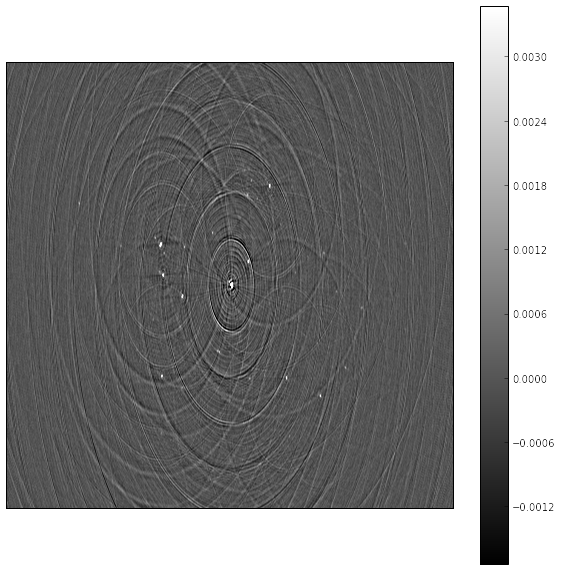

In [8]:
scal.source = s0
scal.output = 'output'
scal.setup()
lib.qimplot('image', rmin=-2, rmax=4)

## SelfCal

In [16]:
# scal.invert is attached to the invert task.
# Defaults for the map and beam parameters are set in the next block
# Change parameters as follows:

scal.source = s0
scal.output = 'selfcal_3'

scal.selfcal.select = '-uvrange(0,0.5)'
scal.selfcal.options = 'mfs,phase'
scal.selfcal.refant = '2'
scal.selfcal.interval = 2
scal.selfcal.clip = 1e-6

# SelfCal and Image Cycle Settings
# Number of Major Cycles
scal.num_image = 3
# Number of minor cycles - The number of image cycles
scal.num_clean = 3

# The mask cutoffs will go from immax/cmin...
scal.cmin = 5
# to a minimum of imax/cmax
scal.cmax = 50
# If linear is True, then the mask cutoffs will decrease linearly.
# If linear is False, then the mask cutoffs will be decrease logarithmically, 
# with log10(cmin) and log10(cmax) as the minimum and maximum denominators respectively.
scal.linear = True 
# This is how much deeper than the mask cutoff that we will clean to.
scal.d = 10.
# Cleaning and masking will stop at 7*theoretical rms 
scal.nsigma = 5
# dummy value for the image maximum
scal.immax = 0.0
scal.rmgains = True # Remove gains from vis file.

scal.setup()

scal.go()

selfcal - WARNING : Cannot find /home/frank/tutorials/tutorial-ngc4278/selfcal_3, making it 
selfcal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ngc4278/selfcal_3
selfcal - WARNING : All outputs will be relative to this path.
selfcal - INFO : Making symbolic/soft link to your visibility file
masher - INFO : obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - ERROR : ### Informational [obsrms]:  inttime in minutes

miriad obsrms - INFO : Completed.
selfcal - INFO : Starting SelfCal
selfcal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ngc4278/selfcal_3
selfcal - WARNING : All outputs will be relative to this path.
selfcal - INFO : Making symbolic/soft link to your visibility file
basher - ERROR : ln: failed to create symbolic link `./src.uv_chan0': File exists

masher - INFO : obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - ERROR : #

selfcal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ngc4278/selfcal_3
selfcal - WARNING : All outputs will be relative to this path.
selfcal - INFO : Making symbolic/soft link to your visibility file
basher - ERROR : ln: failed to create symbolic link `./src.uv_chan0': File exists

masher - INFO : obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - ERROR : ### Informational [obsrms]:  inttime in minutes

miriad obsrms - INFO : Completed.
QIMPLOT - INFO : Quick Image Plot
masher - INFO : fits in_=image out=image.fits op=xyout 
miriad fits - INFO : Completed.
QIMPLOT - INFO : RMS = 0.00083
QIMPLOT - INFO : Plotting from -2*RMS to 4*RMS


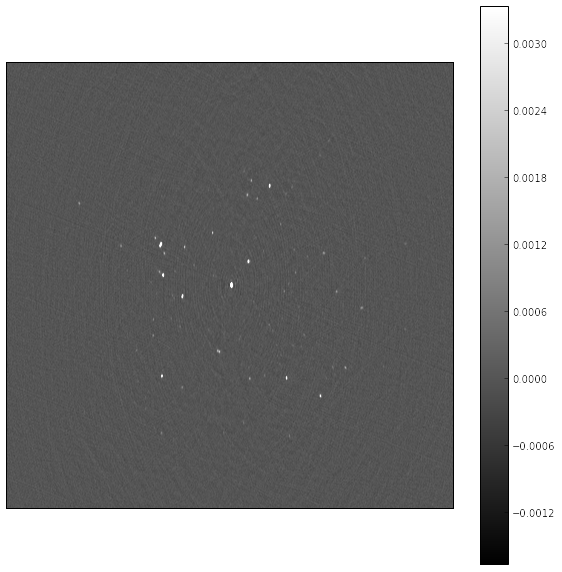

In [7]:
scal.source = s0
scal.output = 'selfcal_3'
scal.setup()
lib.qimplot('image', rmin=-2, rmax=4)